In [1035]:
import boto3
import time
import pandas as pd
import numpy as np
import awswrangler
import seaborn as sns
import matplotlib.pyplot as plt
from tsfresh.feature_selection.relevance import calculate_relevance_table
from tsfresh import extract_features, feature_extraction
from scipy.signal import savgol_filter, medfilt
from scipy import fftpack

## Connect to AWS Athena and query data

In [770]:
query = f"""
    SELECT
        *,
        case when uuid like '%_walk_%' then true else false end as target
    FROM
        "smu-iot"."microbit"
    WHERE
        seconds IS NOT null
    ORDER BY
        uuid, timestamp, seconds
"""

In [771]:
df = awswrangler.athena.read_sql_query(sql=query, database="smu-iot")

## EDA

How does walking vs non-walking data look like ? We need to visualise a total of 6 axis

* `accel-x`
* `accel-y`
* `accel-z`
* `gyro-x`
* `gyro-y`
* `gyro-z`

### Walking

In [772]:
cols = [
    'accel_x',
    'gyro_x',
    'accel_y',
    'gyro_y',
    'accel_z',
    'gyro_z'
]

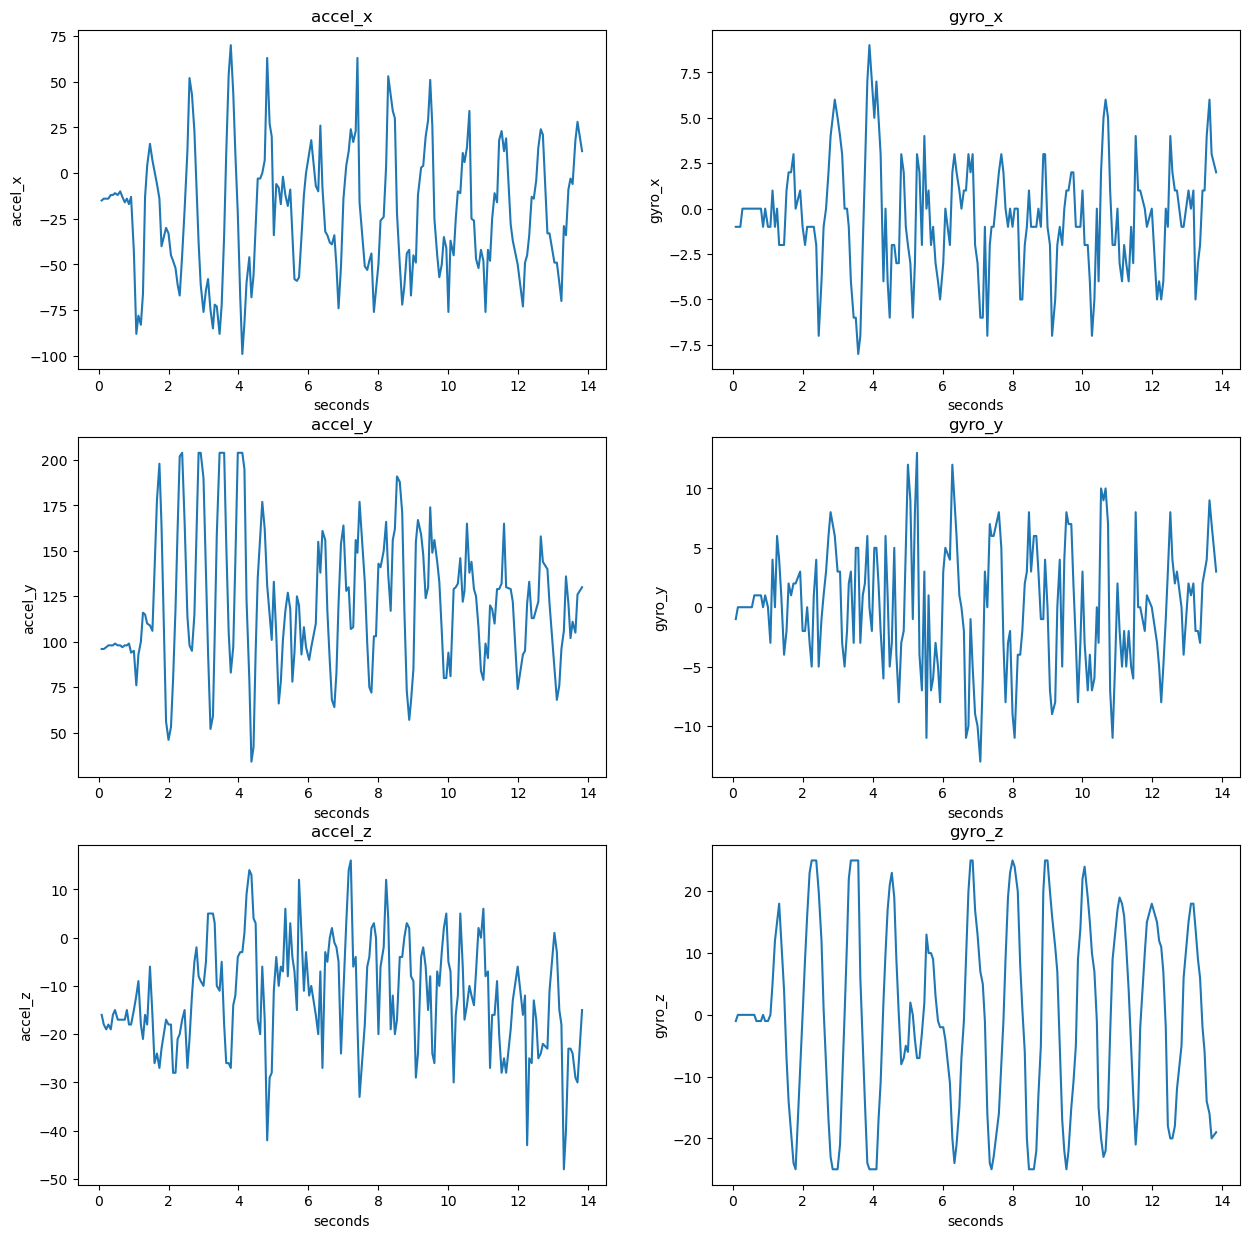

In [773]:
fig = plt.figure(figsize=(15,15))

for idx, item in enumerate(cols):
    
    ax = fig.add_subplot(3, 2, idx + 1)
    ax.set_title(item)
    sns.lineplot(data=df.query("uuid == 'songhan_walk_1'")[:200], x='seconds', y=item, ax=ax)

## Non-Walking

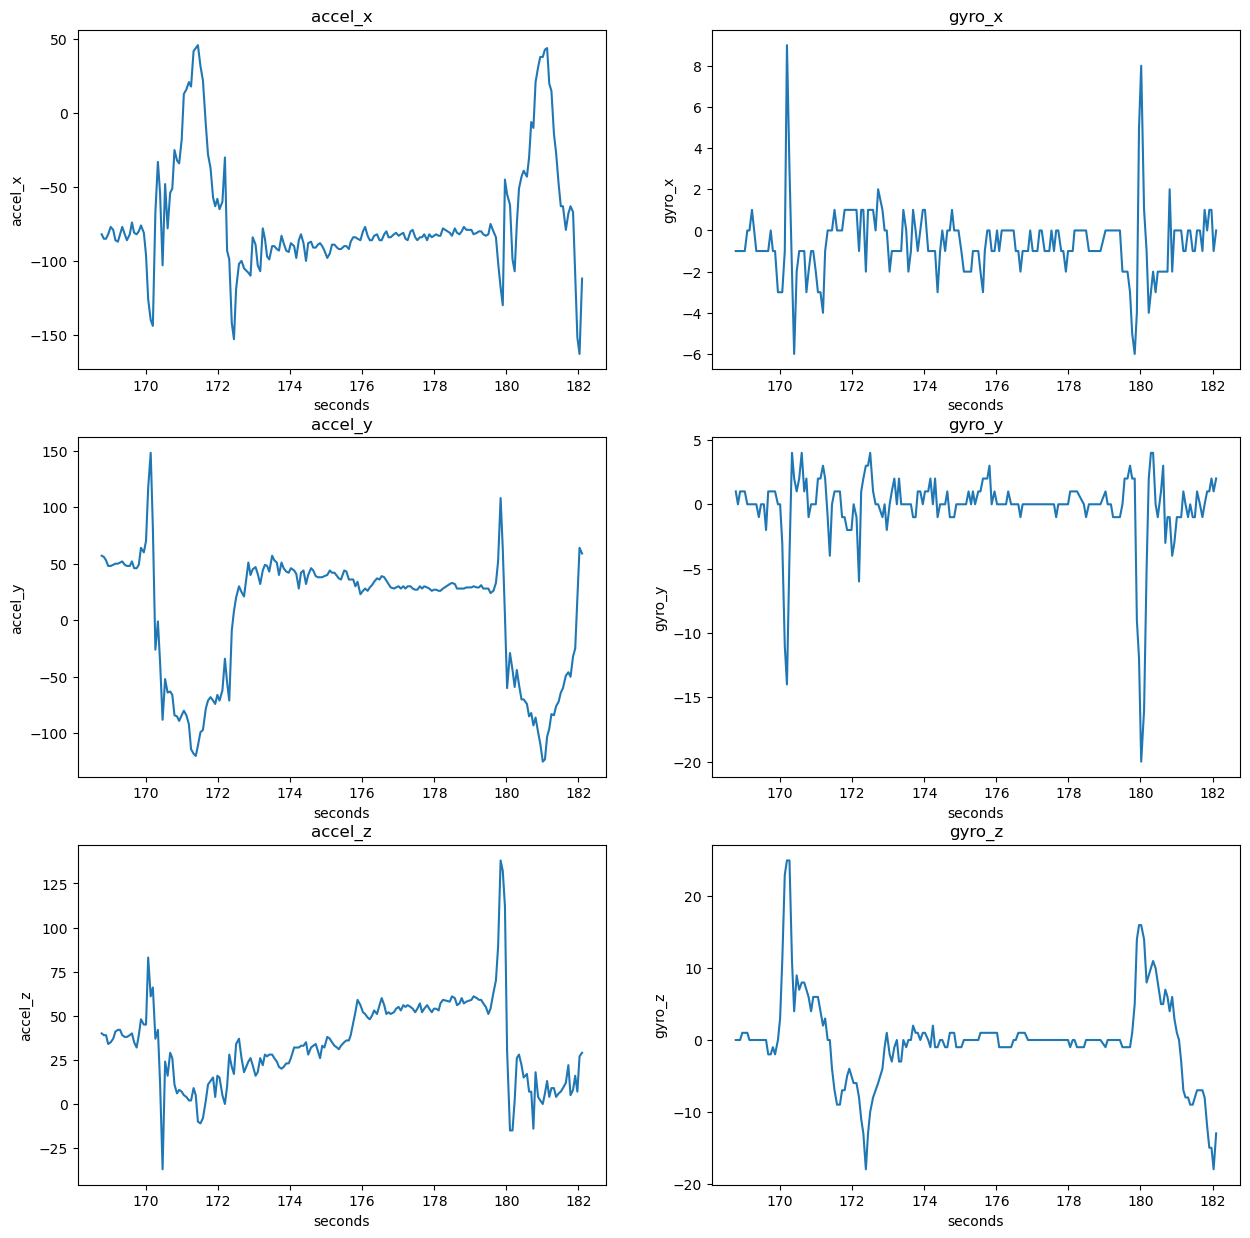

In [774]:
fig = plt.figure(figsize=(15,15))

for idx, item in enumerate(cols):
    
    ax = fig.add_subplot(3, 2, idx + 1)
    ax.set_title(item)
    sns.lineplot(data=df.query("uuid == 'licheng_situps_1'")[:200], x='seconds', y=item, ax=ax)

## Explore Preprocessing libraries

Based on this [paper](https://ieeexplore.ieee.org/document/8672772), we can use the following pre-processing methods:

* Spike Removal
    * Median filter - remove outlier data
* Noise Removal 
    * Savitzky-Golay smoothing filter

## Apply Window Operation

But first, We need to apply preprocessing operations and time series features extraction over a window period. To do so, we first need to determine an appropriate time interval for window operation.

Let's take a look at one of the variables - `gyro_z`.

From the graph below, we know that one period of step takes around 1 second. A brief estimation for an appropriate window period should cover at least several periods. 

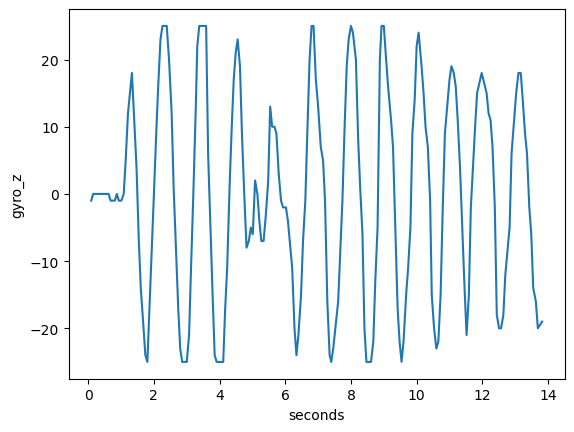

In [775]:
_ = sns.lineplot(data=df.query("uuid == 'songhan_walk_1'")[:200], x='seconds', y='gyro_z')

## Fourier Transform

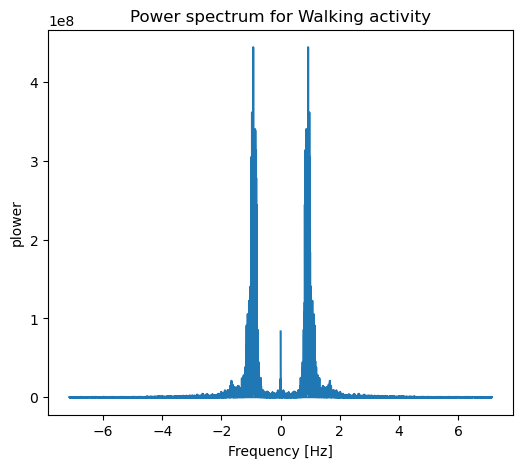

In [776]:
sig_fft = fftpack.fft(df[df.uuid.str.contains('walk')]['gyro_z'].values)

# And the power (sig_fft is of complex dtype)
power = np.abs(sig_fft)**2
sample_freq = fftpack.fftfreq(len(df[df.uuid.str.contains('walk')]), d=0.07)


plt.figure(figsize=(6, 5))
plt.plot(sample_freq, power)
plt.xlabel('Frequency [Hz]')
_ = plt.ylabel('plower')
_ = plt.title('Power spectrum for Walking activity')

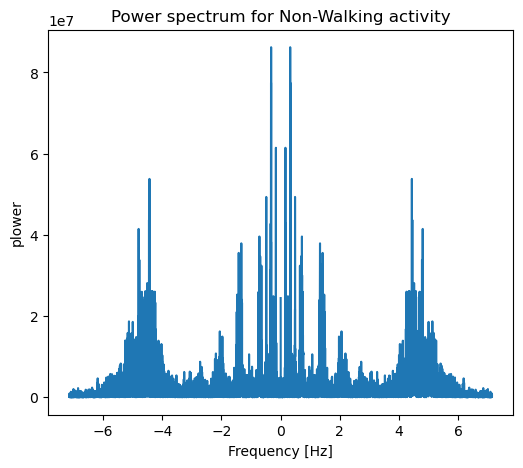

In [777]:
sig_fft = fftpack.fft(df[~df.uuid.str.contains('walk')]['gyro_z'].values)

# And the power (sig_fft is of complex dtype)
power = np.abs(sig_fft)**2
sample_freq = fftpack.fftfreq(len(df[~df.uuid.str.contains('walk')]), d=0.07)

plt.figure(figsize=(6, 5))
plt.plot(sample_freq, power)
plt.xlabel('Frequency [Hz]')
_ = plt.ylabel('plower')
_ = plt.title('Power spectrum for Non-Walking activity')

## What is the time window ?

We can see from fourier analysis, that the typical cycle period for walking activity is about 1 Hz, or 1 sec period. 

We propose to use a window period of **5 seconds**.

In [778]:
df[['seconds']].diff(periods=1).describe()

,seconds
count,44399.000000
mean,0.003799
std,4.409865
min,-299.380005
25%,0.059998
50%,0.069992
75%,0.070007
max,4.860001


The median of time interval between each data record is 0.07 seconds. So we need to use **n = 70** for time window.

In [781]:
window_n = 70

In [941]:
def smooth_filter(
    df, 
    cols,
    apply_median=True,
    apply_sg=True,
    **kwargs,
) -> pd.DataFrame :
    """
    Args:
        df: Pandas series
        cols: DataFrame columns
    
    Returns:
        Pandas DataFrame with smoothed time series 
    """
        
    new_cols = [c + '_post' for c in cols]
    df[new_cols] = np.nan
    window_length = kwargs['window_length']
    window_n = kwargs['window_n']
    ts_id = 0
        
    for item in df.uuid.unique():
        start_idx = df.query(f"uuid == '{item}'").index[0]
        end_idx = df.query(f"uuid == '{item}'").index[-1]
        for idx in range(start_idx, end_idx, window_n):
            if apply_median:
                df.loc[idx:min(idx + window_n - 1,end_idx), new_cols] = \
                df.loc[idx:min(idx + window_n - 1,end_idx), cols].apply(medfilt, axis=0).values
            if apply_sg:
                window_length = min(min(idx + window_n - 1,end_idx) - idx, window_length)
                polyorder = window_length // 2
                df.loc[idx:min(idx + window_n - 1,end_idx), new_cols] = \
                df.loc[idx:min(idx + window_n - 1,end_idx), cols].apply(savgol_filter, window_length=window_length, 
                                                                        polyorder=polyorder, axis=0).values
            df.loc[idx:min(idx + window_n - 1,end_idx), 'ts_id'] = ts_id
            ts_id += 1
                
    return df

## Median Filter applied

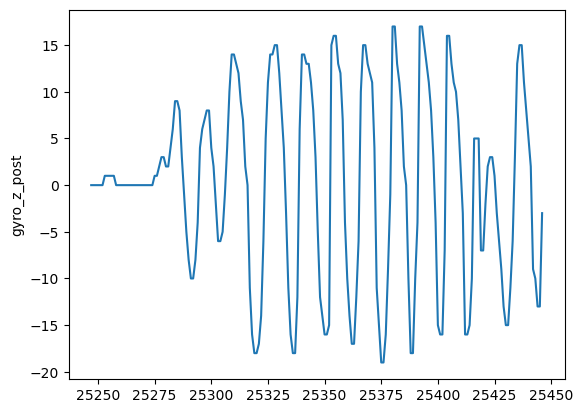

In [942]:
df2 = smooth_filter(df, cols, apply_sg=False, window_length=20, window_n=70)
_ = sns.lineplot(df2.query("uuid == 'spencer_walk_1'")[:200].gyro_z_post)

## Median + SavGol Filter applied

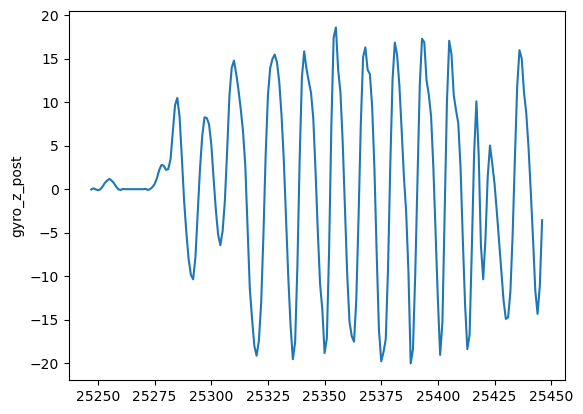

In [943]:
df2 = smooth_filter(df, cols, apply_sg=True, window_length=20, window_n=70)
_ = sns.lineplot(df2.query("uuid == 'spencer_walk_1'")[:200].gyro_z_post)

## Use automated time-series feature extractor from TS fresh

In [944]:
from tsfresh import extract_features

In [948]:
new_cols = [c + '_post' for c in cols]

In [952]:
features = extract_features(df2[['seconds', 'ts_id', *new_cols]], column_id="ts_id", column_sort="seconds").dropna(axis=1)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 30/30 [00:41<00:00,  1.38s/it]


C:\Users\songh\AppData\Local\Temp\ipykernel_7208\3612418889.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2.groupby(['ts_id']).mean()


,timestamp,seconds,gyro_x,gyro_y,gyro_z,accel_x,accel_y,accel_z,target,accel_x_post,gyro_x_post,accel_y_post,gyro_y_post,accel_z_post,gyro_z_post,id
ts_id,,,,,,,,,,,,,,,,
0.0,1677075254.0,2.290714,1.000000,2.414286,-2.171429,-37.471428,91.128571,-46.714287,1.0,-37.619667,1.000000,91.337144,2.395789,-46.790903,-2.128211,1.0
1.0,1677075254.0,6.889714,1.028571,0.114286,-1.000000,-36.285713,91.528572,-48.971428,1.0,-36.403409,0.995991,91.566640,0.129904,-49.066192,-0.986946,1.0
2.0,1677075254.0,11.737143,0.385714,1.471429,-1.114286,-40.200001,93.500000,-47.714287,1.0,-40.189562,0.298189,93.313981,1.401899,-47.900687,-1.074550,1.0
3.0,1677075254.0,16.441286,0.057143,0.900000,-0.700000,-37.428570,88.442856,-46.814285,1.0,-37.373781,0.073620,88.442642,0.880147,-46.843168,-0.676031,1.0
4.0,1677075254.0,21.094715,1.228571,1.600000,-1.900000,-37.614285,85.671425,-48.599998,1.0,-37.629735,1.264472,85.642125,1.696753,-48.648398,-1.907318,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1334.0,1677134972488.442871,268.549133,-1.157143,-1.214286,-1.942857,-13.214286,-39.200001,-13.171429,0.0,-13.214286,-1.085714,-39.242857,-1.100000,-12.200000,-1.585714,1.0
1335.0,1677134977240.628662,273.300873,-0.700000,-0.357143,-2.614286,-3.542857,-31.114286,-17.657143,0.0,-0.628571,-0.628571,-30.435714,-0.250000,-17.028571,-2.692857,1.0
1336.0,1677134982013.74292,278.074585,-0.942857,-0.171429,-3.400000,-16.557142,-32.871429,-27.242857,0.0,-15.985714,-0.985714,-32.435714,-0.178571,-27.221429,-3.757143,1.0


In [1061]:
df3 = df2.groupby(['ts_id']).max().join(features, on=['ts_id'])

In [1062]:
feature_columns = features.columns.values

In [1063]:
df_ml = df3[np.append(feature_columns, ['target'])]

In [1064]:
relevant_features_tb = calculate_relevance_table(df_ml[feature_columns], df_ml['target'])

In [1065]:
x_features = relevant_features_tb[relevant_features_tb.relevant == True].feature

In [1066]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [1067]:
X_train, X_test, y_train, y_test = train_test_split(df_ml[x_features], df_ml['target'], test_size=0.33, random_state=42)

In [1068]:
clf = LogisticRegression()

In [1069]:
clf.fit(X_train, y_train)

C:\Users\songh\anaconda3\envs\smu-iot\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [1086]:
clf.score(X_test, y_test.astype(np.int))

C:\Users\songh\AppData\Local\Temp\ipykernel_7208\3914469023.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  clf.score(X_test, y_test.astype(np.int))


0.9811320754716981

In [1087]:
from sklearn.metrics import f1_score

In [1088]:
f1_score(clf.predict(X_test), y_test.astype(np.int))

C:\Users\songh\AppData\Local\Temp\ipykernel_7208\1112593434.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  f1_score(clf.predict(X_test), y_test.astype(np.int))


0.9849624060150376